In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/DL/dl-2020-unibuc-cv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import os

import numpy as np

import keras
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers, models, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from skimage import io
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [ ]:
def summarize_diagnostics(history):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
with open('/content/train.txt') as f:
    content = f.readlines()
train_data = np.array([io.imread('/content/train/' + x.strip().split(',')[0]).astype('float64') for x in content],  dtype=np.float32)
train_labels = np.array([int(x.strip().split(',')[1]) for x in content])

with open('/content/validation.txt') as f:
    content = f.readlines()
val_data = np.array([io.imread('/content/validation/' + x.strip().split(',')[0]).astype('float64') for x in content],  dtype=np.float32)
val_labels = np.array([int(x.strip().split(',')[1]) for x in content])

data = np.concatenate((train_data, val_data), axis=0)
for idx in range(len(data)):
    data[idx] /= 255
data -= np.mean(data)
labels = np.concatenate((train_labels, val_labels), axis=0)
labels = np.array([to_categorical(label, 8) for label in labels])

def split_data(data, labels):
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=800, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=800, random_state=42)
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

# train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(data, labels)

# print(train_data.shape, train_labels.shape)
# print(val_data.shape, val_labels.shape)
# print(test_data.shape, test_labels.shape)

## Customized Pretrained VGG19 

In [ ]:
def build_model():
    from tensorflow.keras.applications import VGG19

    base_model = VGG19(weights='imagenet', include_top=False, 
                       input_shape=(32, 32, 3))
    
    model = models.Sequential()
    
    for i in range(0, len(base_model.layers - 5)):
        base_model.layers[i].trainable = True
        model.add(base_model.layers[i])
        if base_model.layers[i].name[-5:] == '_pool' and \
             base_model.layers[i].name not in 'block4_pool':
            model.add(layers.Dropout(0.25))
        if base_model.layers[i].name[-5:] in ['conv2', 'conv4']:
            model.add(layers.BatchNormalization())
     
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.01))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=0.01))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(8, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(lr=4e-3, momentum=0.9, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(data, labels)

convnet = build_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                               verbose=0, mode='min', restore_best_weights=True)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, 
                           monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                   patience=10, min_lr=0.5e-8, mode='min', 
                                   verbose=1)

history = convnet.fit(train_data, train_labels, 
                      validation_data=(val_data, val_labels),
                      epochs=30, batch_size=2048, shuffle=True,
                      callbacks=[mcp_save, reduce_lr_loss], verbose=2)

In [ ]:
convnet.load_weights('.mdl_wts.hdf5')
convnet.evaluate(test_data, test_labels, batch_size=64)

In [ ]:
predictions = np.array([np.argmax(pred) for pred in convnet.predict(test_data)])
test_labels = np.array([np.argmax(pred) for pred in test_labels])

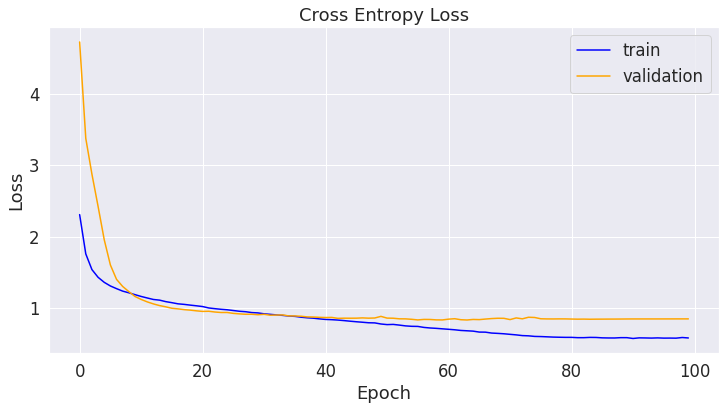

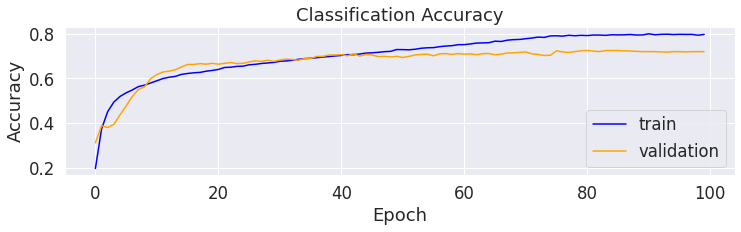

In [ ]:
summarize_diagnostics(history)

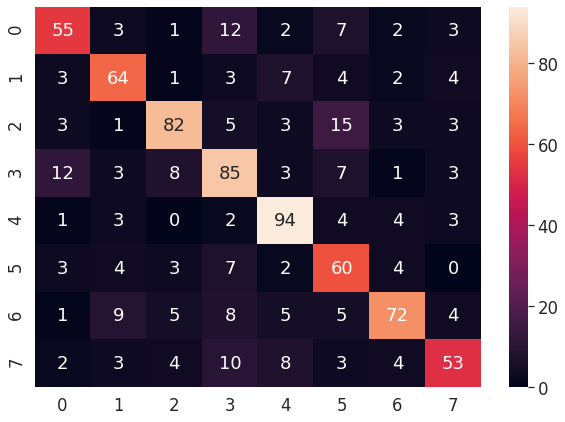

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(8)], columns=[i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
def write_predictions_to_disk(convnet, file_name='cv_submission_vgg'):
    with open('/content/test.txt') as f:
        content = f.readlines()
    submission_data = np.array([io.imread('/content/test/' + x.strip()).astype('float64') for x in content])

    for idx in range(len(content)):
        submission_data[idx] /= 255
    submission_data -= np.mean(submission_data)

    predictions = convnet.predict(submission_data)

    f = open(file_name + '.txt', 'a')
    f.write('id,label\n')

    for image_name, prediction in list(zip(content, predictions)):
        f.write(image_name.strip() + ',' + str(np.argmax(prediction)) + '\n')

    f.close()

## Customized Pretrained VGG19 Ensemble

To run the code in this section you need to load the `write_predictions_to_disk` and `build_model` procedures from the **Customized Pretrained VGG** section.



In [ ]:
round = 0
while round < 9:
    train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(data, labels)

    mcp_save = ModelCheckpoint('.model_' + str(round) + '_weights.hdf5', 
                               save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                       patience=10, min_lr=0.5e-8, mode='min', 
                                       verbose=0)
    
    convnet = build_model()
    history = convnet.fit(train_data, train_labels, 
                          validation_data=(val_data, val_labels),
                          epochs=100, batch_size=2048, shuffle=True,
                          callbacks=[mcp_save, reduce_lr_loss], 
                          verbose=0)
    
    convnet.load_weights('.model_' + str(round) + '_weights.hdf5')
    print('Round ' + str(round + 1))
    loss, acc = convnet.evaluate(test_data, test_labels, batch_size=64)
    if loss < .91:
        write_predictions_to_disk(convnet, 'cv_submission_vgg_' + str(round + 1))
        round += 1

predictions_ensemble = {}

for round in range(9):
    path = 'cv_submission_vgg_' + str(round + 1) + '.txt'
    f = open(path, 'r')
    predictions = f.readlines()
    for row in predictions:
        id = row.split(',')[0].strip()
        if id != 'id':
            label =  int(row.split(',')[1].strip())
            if id not in predictions_ensemble:
                predictions_ensemble[id] = {label: 1}
            else:
                if label not in predictions_ensemble[id]:
                    predictions_ensemble[id][label] = 1
                else:
                    predictions_ensemble[id][label] += 1

f = open('cv_submission_vgg_ensemble.txt', 'a')
f.write('id,label\n')

for key, value in predictions_ensemble.items():
    f.write(key + ',' + str(max(value, key= lambda x: value[x])) + '\n')

f.close()

## VQ-VAE

Used DeepMind's Vector Quantized VAE architecture, introduced in [Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937). An an example for CIFAR-10 can be found [here](https://github.com/deepmind/sonnet/blob/v2/examples/vqvae_example.ipynb).

In [ ]:
!pip install dm-sonnet dm-tree

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
from skimage import io, transform
from sklearn.model_selection import train_test_split

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.3.0
Sonnet version 2.0.0


In [ ]:
train_data_vae, val_data_vae, train_labels_vae, val_labels_vae = train_test_split(data, labels, test_size=0.1, random_state=42)
train_data_variance = np.var(train_data_vae)
val_data_variance = np.var(val_data_vae)
print('train data variance: {}'.format(train_data_variance))
print('val data variance: {}'.format(val_data_variance))

train data variance: 0.12070801109075546
val data variance: 0.11951962858438492


In [ ]:
class ResidualStack(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 name=None):
        super(ResidualStack, self).__init__(name=name)
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._layers = []
        for i in range(num_residual_layers):
            conv3 = snt.Conv2D(output_channels=num_residual_hiddens,
                            kernel_shape=(3, 3), stride=(1, 1),
                            name="res3x3_%d" % i)
            conv1 = snt.Conv2D(output_channels=num_hiddens, kernel_shape=(1, 1),
                            stride=(1, 1), name="res1x1_%d" % i)
            self._layers.append((conv3, conv1))

    def __call__(self, inputs):
        h = inputs
        for conv3, conv1 in self._layers:
            conv3_out = conv3(tf.nn.relu(h))
            conv1_out = conv1(tf.nn.relu(conv3_out))
            h += conv1_out
        return tf.nn.relu(h)

class Encoder(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 name=None):
        super(Encoder, self).__init__(name=name)
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._enc_1 = snt.Conv2D(output_channels=self._num_hiddens // 2,
                                 kernel_shape=(4, 4), stride=(2, 2), 
                                 name="enc_1")
        self._enc_2 = snt.Conv2D(output_channels=self._num_hiddens, 
                                 kernel_shape=(4, 4), stride=(2, 2), 
                                 name="enc_2")
        self._enc_3 = snt.Conv2D(output_channels=self._num_hiddens,
                                 kernel_shape=(3, 3), stride=(1, 1), 
                                 name="enc_3")
        self._residual_stack = ResidualStack(self._num_hiddens,
                                             self._num_residual_layers,
                                             self._num_residual_hiddens)
        self._residual_stack = ResidualStack(self._num_hiddens,
                                             self._num_residual_layers,
                                             self._num_residual_hiddens)
        self._residual_stack = ResidualStack(self._num_hiddens,
                                             self._num_residual_layers,
                                             self._num_residual_hiddens)
    def __call__(self, x):
        h = tf.nn.relu(self._enc_1(x))
        h = tf.nn.relu(self._enc_2(h))
        h = tf.nn.relu(self._enc_3(h))
        return self._residual_stack(h)

class Decoder(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 name=None):
        super(Decoder, self).__init__(name=name)
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._dec_1 = snt.Conv2D(output_channels=self._num_hiddens, 
                                 kernel_shape=(3, 3), stride=(1, 1), 
                                 name="dec_1")
        self._residual_stack = ResidualStack(self._num_hiddens,
                                             self._num_residual_layers,
                                             self._num_residual_hiddens)
        self._residual_stack = ResidualStack(self._num_hiddens,
                                             self._num_residual_layers,
                                             self._num_residual_hiddens)
        self._dec_2 = snt.Conv2DTranspose(output_channels=self._num_hiddens // 2,
                                          output_shape=None, kernel_shape=(4, 4),
                                          stride=(2, 2), name="dec_2")
        self._dec_3 = snt.Conv2DTranspose(output_channels=3, output_shape=None,
                                          kernel_shape=(4, 4), stride=(2, 2),
                                          name="dec_3")
    
    def __call__(self, x):
        h = self._dec_1(x)
        h = self._residual_stack(h)
        h = tf.nn.relu(self._dec_2(h))
        x_recon = self._dec_3(h)
        return x_recon

class VQVAEModel(snt.Module):
    def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
        super(VQVAEModel, self).__init__(name=name)
        self._encoder = encoder
        self._decoder = decoder
        self._vqvae = vqvae
        self._pre_vq_conv1 = pre_vq_conv1
        self._data_variance = data_variance

    def __call__(self, inputs, is_training):
        z = self._pre_vq_conv1(self._encoder(inputs))
        vq_output = self._vqvae(z, is_training=is_training)
        x_recon = self._decoder(vq_output['quantize'])
        recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
        loss = recon_error + vq_output['loss']
        return {'z': z, 'x_recon': x_recon, 'loss': loss,
                'recon_error': recon_error, 'vq_output': vq_output}

In [ ]:
# Set hyper-parameters.
batch_size = 4096
image_size = 32

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 20000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 4
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 2048

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-5

# Data Loading.
train_dataset = (tf.data.Dataset.from_tensor_slices(train_data_vae)
    .shuffle(10000)
    .repeat(-1)
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (tf.data.Dataset.from_tensor_slices(val_data_vae)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

In [ ]:
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim, kernel_shape=(1, 1),
                          stride=(1, 1), name="to_vq")

if vq_use_ema:
    vq_vae = snt.nets.VectorQuantizerEMA(embedding_dim=embedding_dim,
                                         num_embeddings=num_embeddings,
                                         commitment_cost=commitment_cost,
                                         decay=decay)
else:
    vq_vae = snt.nets.VectorQuantizer(embedding_dim=embedding_dim,
                                      num_embeddings=num_embeddings,
                                      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        model_output = model(data, is_training=True)
    trainable_variables = model.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply(grads, trainable_variables)

    return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):
    train_results = train_step(data)
    train_losses.append(train_results['loss'])
    train_recon_errors.append(train_results['recon_error'])
    train_perplexities.append(train_results['vq_output']['perplexity'])
    train_vqvae_loss.append(train_results['vq_output']['loss'])

    if (step_index + 1) % 100 == 0:
        print('%d train loss: %f ' % (step_index + 1, np.mean(train_losses[-100:])) +
            ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
            ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
            ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
    if step_index == num_training_updates:
        break

100 train loss: 0.792440 recon_error: 0.781 perplexity: 24.630 vqvae loss: 0.011
200 train loss: 0.443491 recon_error: 0.412 perplexity: 10.108 vqvae loss: 0.032
300 train loss: 0.284877 recon_error: 0.260 perplexity: 12.791 vqvae loss: 0.025
400 train loss: 0.242599 recon_error: 0.214 perplexity: 14.971 vqvae loss: 0.029
500 train loss: 0.214823 recon_error: 0.183 perplexity: 18.473 vqvae loss: 0.032
600 train loss: 0.189670 recon_error: 0.163 perplexity: 23.484 vqvae loss: 0.026
700 train loss: 0.176056 recon_error: 0.151 perplexity: 28.058 vqvae loss: 0.025
800 train loss: 0.166381 recon_error: 0.141 perplexity: 33.342 vqvae loss: 0.025
900 train loss: 0.157028 recon_error: 0.133 perplexity: 39.327 vqvae loss: 0.024
1000 train loss: 0.148772 recon_error: 0.126 perplexity: 45.717 vqvae loss: 0.023
1100 train loss: 0.141614 recon_error: 0.120 perplexity: 52.809 vqvae loss: 0.022
1200 train loss: 0.135085 recon_error: 0.114 perplexity: 60.847 vqvae loss: 0.021
1300 train loss: 0.129493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 127.5, -0.5)

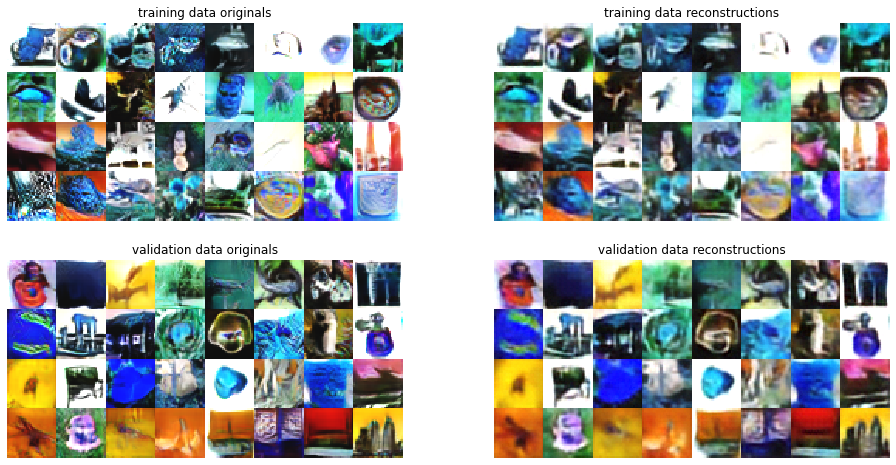

In [ ]:
# Reconstructions
train_batch = next(iter(train_dataset))[:32]
valid_batch = next(iter(valid_dataset))[:32]

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch[:],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch[:],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
    reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
                           .transpose(0, 2, 1, 3, 4)
                           .reshape(4 * 32, 8 * 32, 3))
    return reshaped + 0.5

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch[:].numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch[:].numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

In [ ]:
train_recon_data, train_recon_labels = [], []

for sample, label in list(zip(train_data, train_labels)):
    train_recon_data.append(model(sample.reshape(1, 32, 32, 3)[:],
                                  is_training=False)['x_recon'].numpy())
    train_recon_labels.append(label)

In [ ]:
train_data.shape

(31410, 32, 32, 3)

In [ ]:
train_data = np.concatenate((train_data, np.array(train_recon_data).reshape((31410, 32, 32, 3))), axis = 0)
train_labels = np.concatenate((train_labels, np.array(train_recon_labels)), axis = 0)

In [ ]:
val_recon_data, val_recon_labels = [], []

for sample, label in list(zip(val_data, val_labels)):
    val_recon_data.append(model(sample.reshape(1, 32, 32, 3)[:],
                                  is_training=False)['x_recon'].numpy())
    val_recon_labels.append(label)

val_data = np.concatenate((val_data, np.array(val_recon_data).reshape((3150, 32, 32, 3))), axis = 0)
val_labels = np.concatenate((val_labels, np.array(val_recon_labels)), axis = 0)

In [ ]:
test_recon_data, test_recon_labels = [], []

for sample, label in list(zip(test_data, test_labels)):
    test_recon_data.append(model(sample.reshape(1, 32, 32, 3)[:],
                                 is_training=False)['x_recon'].numpy())
    test_recon_labels.append(label)

test_data = np.concatenate((test_data, np.array(test_recon_data).reshape((3501, 32, 32, 3))), axis = 0)
test_labels = np.concatenate((test_labels, np.array(test_recon_labels)), axis = 0)

## ResNet Self-Supervised Learning

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
        except RuntimeError as e:
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def preprocess_data(x_train,y_train,x_test,y_test,subtract_pixel_mean=True):
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
    return x_train,y_train,x_test,y_test

def rotate_image(im, iterations=None):
    if not iterations:
        iterations = random.randint(0, 3)
    y = [0, 0, 0, 0]
    y[iterations] = 1
    for i in range(iterations):
        im = np.rot90(im)
    return im, y

In [ ]:
with open('/content/train.txt') as f:
    content = f.readlines()
train_data = np.array([io.imread('/content/train/' + x.strip().split(',')[0]).astype('float64') for x in content])
train_labels = np.array([to_categorical(int(x.strip().split(',')[1]), 8) for x in content])

with open('/content/validation.txt') as f:
    content = f.readlines()
val_data = np.array([io.imread('/content/validation/' + x.strip().split(',')[0]).astype('float64') for x in content])
val_labels = np.array([to_categorical(int(x.strip().split(',')[1]), 8) for x in content])

data = np.concatenate((train_data, val_data), axis=0)
# for idx in range(len(data)):
#     data[idx] /= 255
# data -= np.mean(data)
labels = np.concatenate((train_labels, val_labels), axis=0)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

In [ ]:
### Resnet Implementation taken from David Yang

def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
    
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=8):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def make_rotated_data(Train, Test, subtract_pixel_mean=True):
    model_name='cifar100SLL'
    xy_rot_train = list(zip(*[rotate_image(im) for im in Train[0]]))
    xy_rot_test = list(zip(*[rotate_image(im) for im in Test[0]]))
    
    x_rot_train=np.array(xy_rot_train[0][:]).astype('float32') / 255
    y_rot_train=np.array(xy_rot_train[1][:])
    x_rot_test=np.array(xy_rot_test[0][:]).astype('float32') / 255
    y_rot_test=np.array(xy_rot_test[1][:])
    
    if subtract_pixel_mean:
        x_rot_train_mean = np.mean(x_rot_train, axis=0)
        x_rot_train -= x_rot_train_mean
        x_rot_test -= x_rot_train_mean
    
    return x_rot_train, y_rot_train, x_rot_test, y_rot_test

In [ ]:
def make_ssl_backbone(Train, Test, save_dir, input_shape=(32,32,3), n=3,
                      model_name='Restnetv1_SSL_Rotation.h5'):
    x_rot_train, y_rot_train, x_rot_test, y_rot_test = make_rotated_data(Train, 
                                                                         Test)
    # Computed depth from supplied model parameter n
    depth = n * 6 + 2
    
    resnet_model= resnet_v1(input_shape=input_shape, depth=depth)
    x = Dense(4, activation='softmax')(resnet_model.layers[-2].output)
    model = keras.Model(resnet_model.inputs, x)

    filepath = os.path.join(save_dir, model_name)
    # Prepare callbacks for model saving and for learning rate adjustment.
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, 
                                   verbose=1, mode='max', restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',
                                 verbose=1, save_best_only=True)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0,
                                   patience=10, min_lr=0.5e-6)
    callbacks = [checkpoint, lr_reducer, lr_scheduler, early_stopping]

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    history_SSL = model.fit(x_rot_train, y_rot_train,
                            validation_data=(x_rot_test, y_rot_test),
                            batch_size=512, epochs=200, callbacks=callbacks)
    
    model.save('Restnetv1_SSL_Rotation')
    
    with open('Restnetv1_SSL_Rotation.h5_history','wb') as fp:
        pickle.dump(history_SSL.history, fp)

    return model, history_SSL

In [ ]:
resnet_ssl, history_ssl = make_ssl_backbone((train_data, train_labels), 
                                            (val_data, val_labels),
                                            save_dir='saved_models')

Learning rate:  0.001
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 1.5993 - accuracy: 0.3919
Epoch 00001: val_accuracy improved from -inf to 0.30889, saving model to saved_models/Restnetv1_SSL_Rotation.h5
56/56 [==============================] - 4s 79ms/step - loss: 1.5993 - accuracy: 0.3919 - val_loss: 1.8355 - val_accuracy: 0.3089
Learning rate:  0.001
Epoch 2/200
55/56 [============================>.] - ETA: 0s - loss: 1.2460 - accuracy: 0.5409
Epoch 00002: val_accuracy improved from 0.30889 to 0.51079, saving model to saved_models/Restnetv1_SSL_Rotation.h5
56/56 [==============================] - 4s 68ms/step - loss: 1.2458 - accuracy: 0.5412 - val_loss: 1.2794 - val_accuracy: 0.5108
Learning rate:  0.001
Epoch 3/200
55/56 [============================>.] - ETA: 0s - loss: 1.0958 - accuracy: 0.6183
Epoch 00003: val_accuracy did not improve from 0.51079
56/56 [==============================] - 4s 68ms/step - loss: 1.0951 - accuracy: 0.6186 - val_loss: 1.3297 

Text(0.5, 1.0, 'Loss - Self-Supervised Image Rotation Pretext Task')

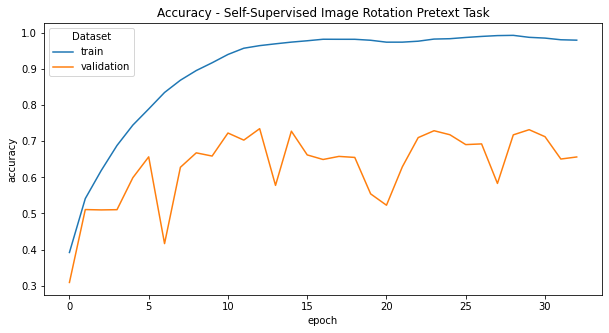

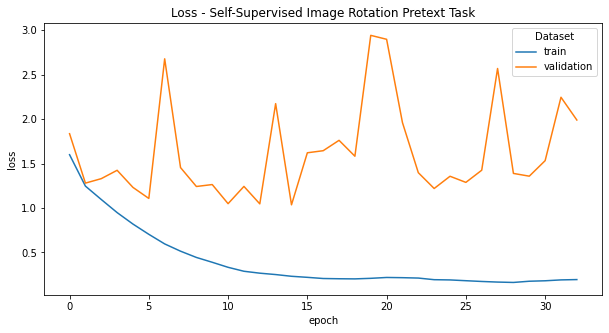

In [ ]:
with open("Restnetv1_SSL_Rotation.h5_history",'rb') as fp:
        history = pickle.load(fp)

ssl_df=pd.DataFrame({'loss': history['loss'] + history['val_loss'],
                     'accuracy': history['accuracy'] + history['val_accuracy'],
                     'Dataset':'train'})
ssl_df.loc[len(ssl_df) // 2:, 'Dataset'] = 'validation'
ssl_df['epoch'] = np.concatenate((np.arange(len(history['loss'])),
                                  np.arange(len(history['loss']))))

figure = plt.figure(figsize=(10,5))
g = sns.lineplot(y='accuracy',x='epoch',hue='Dataset',data=ssl_df)
g.set_title('Accuracy - Self-Supervised Image Rotation Pretext Task')

figure = plt.figure(figsize=(10,5))
g = sns.lineplot(y='loss',x='epoch',hue='Dataset',data=ssl_df)
g.set_title('Loss - Self-Supervised Image Rotation Pretext Task')

In [ ]:
with open('/content/train.txt') as f:
    content = f.readlines()
train_data = np.array([io.imread('/content/train/' + x.strip().split(',')[0]).astype('float64') for x in content])
train_labels = np.array([int(x.strip().split(',')[1]) for x in content])

with open('/content/validation.txt') as f:
    content = f.readlines()
val_data = np.array([io.imread('/content/validation/' + x.strip().split(',')[0]).astype('float64') for x in content])
val_labels = np.array([int(x.strip().split(',')[1]) for x in content])

In [ ]:
def train_models_datasplit(x_train, y_train, x_test, y_test,
                           batch_size = 512, epochs=200, data_augmentation=False,
                           num_classes=8, n=3, ssl_path=None, input_shape=(32,32,3), 
                           dataset='hallucination', data_fraction_increment=0.1,
                           num_increments=10, random_state=689):
     
    ###Calcualte number of many kfolds splits 
    n_splits=int(1/data_fraction_increment)
        
    # Convert class vectors to binary class matrices.
    # y_test = keras.utils.to_categorical(y_test, num_classes)
    # Computed depth from supplied model parameter n
    depth = n * 6 + 2
    # Model name, depth and version
    model_type = 'ResNet%d' % depth
    
    ###Calcualte number of many kfolds splits 
    n_splits = int(1 / data_fraction_increment)
    
    ##Ensure that data increments consist of class balanced data
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state)
    
    histories = []
    for i,index  in enumerate(skf.split(x_train, y=y_train)):
        if i > num_increments - 1:
            break
        if i > 0:
            test_index = np.concatenate((test_index, index[1]))
        else:
            test_index = index[1]
        y_train_t = keras.utils.to_categorical(y_train, num_classes)[test_index]
        if ssl_path:
            ssl_model=keras.models.load_model(ssl_path)
            x=model=ssl_model.layers[-2].output
            x = Dense(8, activation='softmax')(x)
            model = keras.Model(ssl_model.inputs,x)
        else:
            model = resnet_v1(input_shape=input_shape, depth=depth)
        
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=lr_schedule(0)),
                      metrics=['accuracy'])
        model.summary()
        print(model_type)
        # Prepare model model saving directory.
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = dataset + '_%s_model.h5' % model_type +"_"+ str((i/n_splits)*100)
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        
        # Prepare callbacks for model saving and for learning rate adjustment.
#         checkpoint = ModelCheckpoint(filepath=filepath,
#                                      monitor='val_loss',
#                                      verbose=1,
#                                      save_best_only=True)
        lr_scheduler = LearningRateScheduler(lr_schedule)
        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                       cooldown=0,
                                       patience=5,
                                       min_lr=0.5e-6)
        callbacks = [lr_reducer, lr_scheduler]
        
        # Run training, with or without data augmentation.
        if not data_augmentation:
            print('Not using data augmentation.')
            y_train = np.array([to_categorical(y, 8) for y in y_train])
            y_test = np.array([to_categorical(y, 8) for y in y_test])
            print(x_train.shape, y_train.shape)
            print(x_test.shape, y_test.shape)
            model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      shuffle=True,
                      callbacks=callbacks)
        else:
            print('Using real-time data augmentation.')
            # This will do preprocessing and realtime data augmentation:
            datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # epsilon for ZCA whitening
                zca_epsilon=1e-06,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # set range for random shear
                shear_range=0.,
                # set range for random zoom
                zoom_range=0.,
                # set range for random channel shifts
                channel_shift_range=0.,
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                # value used for fill_mode = "constant"
                cval=0.,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False,
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0)
            # Compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            datagen.fit(x_train)
            # Fit the model on the batches generated by datagen.flow().
            histories.append(model.fit_generator(datagen.flow(x_train[test_index], y_train_t, batch_size=batch_size),
                                epochs=epochs, verbose=1, workers=4,validation_data=(x_test,y_test),
                                callbacks=callbacks))
            
        # Record performance of trained model.
        train_maxes = []
        val_maxes = []
        val_loss = []
        train_loss = []
        if ssl_path:
            record_path = dataset +'_self_supervised.csv'
        else:
            record_path = dataset +'_supervised.csv'

        for i in range(len(histories)):
            val_maxes.append(max(histories[i].history['val_accuracy']))
            train_maxes.append(max(histories[i].history['accuracy']))
            val_loss.append(min(histories[i].history['val_loss']))
            train_loss.append(min(histories[i].history['loss']))
        
        pd.DataFrame({'Val_Accuracy':val_maxes,
                      'Train_Accuracy':train_maxes,
                      'Val_Loss':val_loss,'Train_Loss':train_loss}).to_csv(record_path)

In [ ]:
### Run experiment with WITH self-supervision
x_train, y_train, x_test, y_test = preprocess_data(train_data, train_labels, 
                                                   val_data, val_labels)

train_models_datasplit(x_train, y_train, x_test, y_test,
                       data_fraction_increment=0.02, batch_size=32,
                       num_increments=10, 
                       ssl_path='Restnetv1_SSL_Rotation')